In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
# Reading the data.
def load_dataset(path = './hwk3data/', is_test_type = False):
    filename = 'EMGaussian' 
    if(is_test_type):
        filename += ".test"
    else:
        filename += ".train"
    data = np.loadtxt(path + filename)
    return data

In [3]:
def kmeans(init_type = 0, k = 4, is_plot = True, is_save = True, format='eps'):
    X = load_dataset()
    num_data = X.shape[0]
    num_features = X.shape[1]
    centers = None
    sse_error = 0
    mixings = np.zeros(k)
    if init_type == 0 :
        mean = np.mean(X, axis = 0)
        std = np.std(X, axis = 0)
        # Getting random samples from N(mu,std)
        centers = np.random.randn(k, num_features)*std + mean
    elif init_type == 1:
        equal_ints = True
        X_min = np.max(X)
        X_max = np.min(X)
        mid = (X_min + X_max)/2.0
        while equal_ints == True :
            centers = np.random.randint(mid-k/2, mid+k/2+1, size=(k,num_features))
            equal_ints = False
            for i in range(len(centers)):
                for j in range(i+1,len(centers)):
                    if centers[i][0] == centers[j][0] and centers[i][1] == centers[j][1]:
                        equal_ints = True
    elif init_type == 2:
        X_min = np.max(X)
        X_max = np.min(X)
        mid = (X_min + X_max)/2.0
        centers = np.random.uniform(mid-k/2, mid+k/2+1, size=(k,num_features))
        
    if is_plot :
        fig , ax = plt.subplots()
        colors=['burlywood', 'deepskyblue', 'hotpink', 'mediumturquoise']
    
    old_centroids = np.zeros(centers.shape) # to store old centers
    new_centroids = deepcopy(centers) # Store new centers

    clusters = np.zeros(num_data)
    distances = np.zeros((num_data,k))

    error = np.linalg.norm(new_centroids - old_centroids)

    while error != 0:
        # Calculating the distance to every centeroid
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - new_centroids[i], axis=1)
        # Labeling data with closest centeroids
        clusters = np.argmin(distances, axis = 1)
        # Storing old centroids
        old_centroids = deepcopy(new_centroids)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            new_centroids[i] = np.mean(X[clusters == i], axis=0)
        error = np.linalg.norm(new_centroids - old_centroids)
    for i in range(k):
        cluster = X[clusters == i]
        mixings[i] = cluster.shape[0]/num_data
        sse_error += np.sum(np.linalg.norm(cluster - new_centroids[i]))
        if is_plot :
            ax.scatter(cluster[:,0], cluster[:,1], c=colors[i], s = 6)
    if is_plot :        
        ax.scatter(new_centroids[:,0], new_centroids[:,1], marker='+', c='black', s=70)
        ax.set_title('kmeans --' + ' Init type: ' + str(init_type) + '-- SSE:' + str(np.round(sse_error,2)))
        ax.set_yticklabels([])
        ax.set_xticklabels([])  
    if is_save and is_plot :
        fig_name = 'figure_' + 'kmeans_' + 'init_type_' + str(init_type) + '.' + format
        fig.savefig(fig_name, format=format, bbox_inches='tight')
    return sse_error, new_centroids, mixings

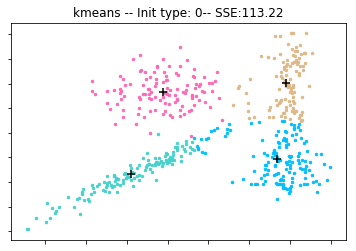

In [4]:
sse_error, _, _ = kmeans(init_type = 0, is_save = True)

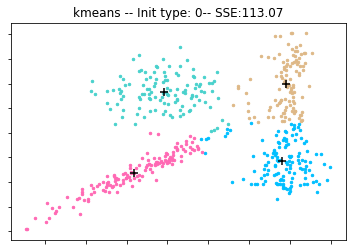

In [153]:
sse_error, _, _ = kmeans(init_type = 0)

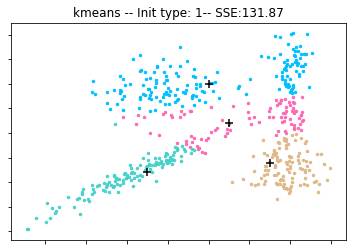

In [154]:
sse_error, _, _ = kmeans(init_type = 1)

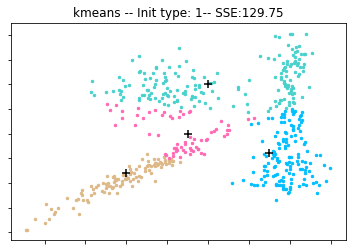

In [155]:
sse_error, _, _ = kmeans(init_type = 1)

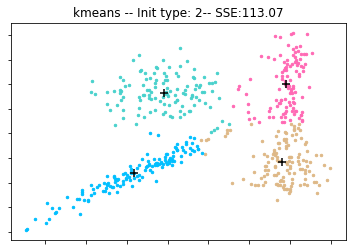

In [156]:
sse_error, _, _ = kmeans(init_type = 2)

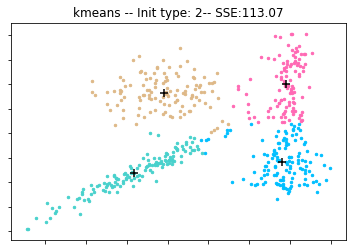

In [157]:
sse_error, _, _ = kmeans(init_type = 2)

## EM -  Mixture of Gaussians 
Let K = 4 and d = 2.

In [5]:
def multi_gaussian(x, mu, sigma):
    return multivariate_normal.pdf(x, mu, sigma)

In [39]:
def draw_ellipse(mu, sigma, ax = None, color="dimgray"):
    ax = ax or plt.gca()
    # Compute eigenvalues and associated eigenvectors
    vals, vecs = np.linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = np.degrees(np.arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    w, h = 2 * np.sqrt(vals)
    ellipse = Ellipse(mu, 2*w, 2*h, theta, color=color)
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_fill(False)
    ellipse.set_linestyle('--')
    ax.add_artist(ellipse) 

In [43]:
def gmm(init_type=0, k=4, error=1e-6, max_it=300,
        is_plot=True, is_save=True, format='eps'):
    
    X = load_dataset()
    num_data = X.shape[0]
    num_features = X.shape[1]
    BIG_DIAG = 25
    if is_plot :
        fig , ax = plt.subplots()
        colors=['burlywood', 'deepskyblue', 'hotpink', 'mediumturquoise']
        
    # For E-Step
    gammas = np.zeros((num_data,k))
    
    # For M-Step
    means = None
    covars = None
    mixings = None
    
    # Stopping conditions
    counter = 0
    old_loglikelihood = 0.0
    new_loglikelihood = 1.0
    
    # Initialization:
    if init_type == 0 :
        _, means, mixings = kmeans(init_type=0, k=k, is_plot=False)
        covars = np.array([np.identity(num_features)]*k)
        for i in range(k):
            covars[i] = covars[i]*np.random.uniform(1,9)
    elif init_type == 1 :
        _, means, mixings = kmeans(init_type=0, k=k, is_plot=False)
        covars = np.random.rand(k,num_features,num_features)
        # Making the Covariance matrix symmetric
        for i in range(k):
            # Adding the constant BIG_DIAG to ensure matrix
            # is positive semi-definite
            covars[i] = (covars[i] + covars[i].T)/2.0 \
            + BIG_DIAG*np.identity(num_features)
    else:
        print('Not supported')
        return
    while (counter < max_it) and (np.abs(new_loglikelihood - old_loglikelihood) > error):
        # Update value of log-likelihood:
        old_loglikelihood = new_loglikelihood
        
        # E-Step:
        # This is the total sum of responsibilities over all observations
        for i in range(num_data):
            total_multi_gauss = 0
            # Calculate the denominator
            for j in range(k):
                total_multi_gauss = total_multi_gauss\
                + mixings[j]*multi_gaussian(X[i],means[j],covars[j])
            # Calculate the responsibilities
            for j in range(k):
                gammas[i,j] = mixings[j]*multi_gaussian(X[i],means[j],covars[j])\
                /total_multi_gauss

        # M-Step: 
        means = np.zeros((k, num_features))
        covars = np.zeros((k, num_features, num_features))
        mixings = np.zeros(k)

        for j in range(k):
            
            # Calculating the sum of responsibilities for gaussian j
            sum_gamma_j = np.sum(gammas[:,j])
            # Updating the means
            for i in range(num_data):
                means[j] += gammas[i,j]*X[i]
            means[j] /= sum_gamma_j
            # Updating the covariances:
            sigmas = np.zeros(k)
            if init_type == 0:
                for i in range(num_data):
                    sigmas[j] += gammas[i,j]*(X[i]-means[j]).reshape(1,2)\
                    .dot((X[i]-means[j]).reshape(2,1))
                sigmas[j] /= num_features*sum_gamma_j
                covars[j] = sigmas[j]*np.eye(num_features)
            elif init_type == 1:
                for i in range(num_data):
                    covars[j] += gammas[i,j]*(X[i]-means[j]).reshape(2,1)\
                    .dot((X[i]-means[j]).reshape(2,1).transpose())
                covars[j] /= sum_gamma_j
            # Updating the mixing coefficients:
            mixings[j] = sum_gamma_j/num_data
        # Calculating log-likelihood:
        for i in range(num_data):
            term = 0
            for j in range(k):
                term += mixings[j]*multi_gaussian(X[i],means[j],covars[j])
            new_loglikelihood += np.log(term)
        new_loglikelihood /= num_data
        
        # Incrementing the counter
        counter += 1
        
    clusters = np.argmax(gammas, 1)
    sse_error = 0
    for j in range(k):
        cluster = X[np.where(clusters == j)]
        sse_error += np.sum(np.linalg.norm(cluster - means[j]))
        if is_plot :
            ax.scatter(cluster[:,0], cluster[:,1], c=colors[j], s = 6)
            ax.scatter(means[j,0], means[j,1], marker='+', c='black', s=70)
            draw_ellipse(means[j], covars[j], ax=ax)
            ax.set_title('GMM --' + ' Init type: ' + str(init_type) +\
                         ' -- norm loglikelihood:' + str(np.round(new_loglikelihood,2))\
                         + ' -- SSE:' + str(np.round(sse_error,2)))
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    if is_save and is_plot :
        fig_name = 'figure_' + 'gmm_' + str(init_type) + '.' + format
        fig.savefig(fig_name, format=format, bbox_inches='tight')
    return (means,covars,mixings,init_type)

In [44]:
def gmm_test(means, covars, mixings, init_type,\
             is_save=True, is_plot=True, format='eps'):
    # Calculate responsibilities:
    X = load_dataset(is_test_type = True)
    num_data = X.shape[0]
    num_features = X.shape[1]
    k = means.shape[0]
    gammas = np.zeros((num_data,k))
    norm_loglikelihood = 0
    if is_plot :
        fig , ax = plt.subplots()
        colors=['burlywood', 'deepskyblue', 'hotpink', 'mediumturquoise']
    for i in range(num_data):
        total_multi_gauss = 0
        # Calculate the denominator
        for j in range(k):
            total_multi_gauss = total_multi_gauss\
            + mixings[j]*multi_gaussian(X[i],means[j],covars[j])
        # Calculate the responsibilities
        for j in range(k):
            gammas[i,j] = mixings[j]*multi_gaussian(X[i],means[j],covars[j])\
            /total_multi_gauss
    # Plot results
    for i in range(num_data):
        term = 0
        for j in range(k):
            term += mixings[j]*multi_gaussian(X[i],means[j],covars[j])
        norm_loglikelihood += np.log(term)
    norm_loglikelihood /= num_data
        
    clusters = np.argmax(gammas, 1)
    sse_error = 0
    for j in range(k):
        cluster = X[np.where(clusters == j)]
        sse_error += np.sum(np.linalg.norm(cluster - means[j]))
        if is_plot :
            ax.scatter(cluster[:,0], cluster[:,1], c=colors[j], s = 6)
            ax.scatter(means[j,0], means[j,1], marker='+', c='black', s=70)
            draw_ellipse(means[j], covars[j], ax=ax)
            ax.set_title('GMM_test --' + ' Init type: ' + str(init_type) +\
                         ' -- norm loglikelihood:' + str(np.round(norm_loglikelihood,2))\
                         + ' -- SSE:' + str(np.round(sse_error,2)))
            ax.set_yticklabels([])
            ax.set_xticklabels([]) 
    if is_save and is_plot :
        fig_name = 'figure_' + 'gmm_test_' + str(init_type) + '.' + format
        fig.savefig(fig_name, format=format, bbox_inches='tight')

### Plotting the results for question (b):

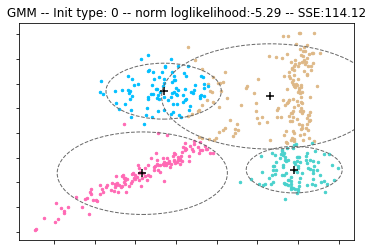

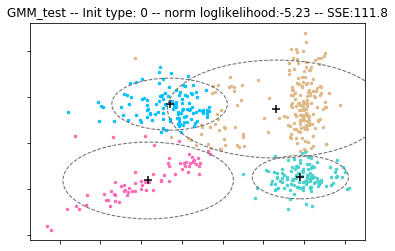

In [45]:
means, covars, mixings, init_type = gmm(init_type = 0, is_plot = True)
gmm_test(means, covars, mixings, init_type, is_plot = True)

### Plotting the results for question (c):

(array([[ 3.80035525, -3.79149738],
        [-3.06133035, -3.53394655],
        [-2.03427493,  4.17267809],
        [ 3.97882133,  3.79091281]]), array([[[ 0.91875839,  0.05686211],
         [ 0.05686211,  1.87793529]],
 
        [[ 6.24460018,  6.05316024],
         [ 6.05316024,  6.18524275]],
 
        [[ 2.90483873,  0.20694286],
         [ 0.20694286,  2.75633751]],
 
        [[ 0.20981511,  0.28643967],
         [ 0.28643967, 12.16048461]]]), array([0.18364071, 0.30558742, 0.25156153, 0.25921033]))

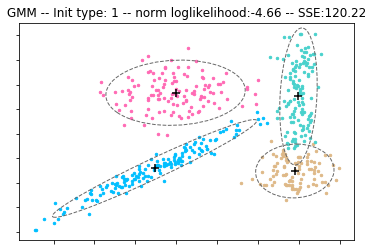

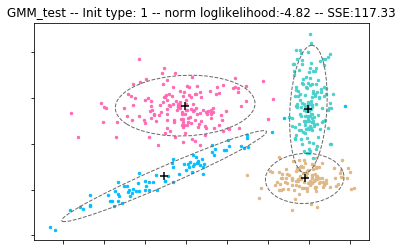

In [165]:
means, covars, mixings, init_type = gmm(init_type = 1, is_plot = True)
gmm_test(means, covars, mixings, init_type, is_plot = True)